<a href="https://colab.research.google.com/github/RRENT5/Augx/blob/Colab_test/ReproducibilityChallenge_RRENT5_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To do list:

    Add aug_list = augmentations.augmentations_all
    Removing data visualization?
    **Done** Delete from cifar 10 and 100 if they agree: dataset="cifar100"
                                                model="net"
                                                learning_rate=0.1
                                                momentum=0.9
                                                decay=0.0001
                                                no_epochs=20
                                                print_frequency=100
    Add cifar100-C? *Done, let's see how it works in terms of time.*

# <center>  **PROJECT - REPRODUCIBILITY CHALLENGE** <center/>

The following code aims to reproduce part of the results on the published paper *AugMix: A simple data processing method to improve robustness and uncertainty*, reusing their methods and choosing the same models to train and test.

In [ ]:
import numpy as np
import torch
import torchvision
import PIL
import math
import time
import os
import shutil

import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F


In [ ]:
args = {

    'epochs': 5,
    'learning-rate': 0.1,
    'batch_size': 128,
    'eval_batch_size': 1000,
    'momentum': 0.9,
    'decay': 0.0005,

    # WRN Options
    'layers': 40,
    'widen_factor': 2,
    'droprate': 0.0,

    #AugMix Options
    'mixture_width': 3,
    'mixture_depth': -1,
    'aug_severity': 3,
    'no_jsd': True,
    'all_ops': True,

    # Checkpointing Options
    'save': './snapshots',
    'resume': '',
    'evaluate': True,
    'print_freq': 100,

    # Acceleration
    'num_workers': 2
}

CORRUPTIONS = [
    'gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur',
    'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog',
    'brightness', 'contrast', 'elastic_transform', 'pixelate',
    'jpeg_compression'
]

The following code block includes the definitions of the **base augmentation operators**

In [ ]:
%%writefile augmentations.py

# Copyright 2019 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

"""Base augmentations operators."""

import numpy as np
from PIL import Image, ImageOps, ImageEnhance

# ImageNet code should change this value
IMAGE_SIZE = 32


def int_parameter(level, maxval):
  """Helper function to scale `val` between 0 and maxval .
  Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.
  Returns:
    An int that results from scaling `maxval` according to `level`.
  """
  return int(level * maxval / 10)


def float_parameter(level, maxval):
  """Helper function to scale `val` between 0 and maxval.
  Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.
  Returns:
    A float that results from scaling `maxval` according to `level`.
  """
  return float(level) * maxval / 10.


def sample_level(n):
  return np.random.uniform(low=0.1, high=n)


def autocontrast(pil_img, _):
  return ImageOps.autocontrast(pil_img)


def equalize(pil_img, _):
  return ImageOps.equalize(pil_img)


def posterize(pil_img, level):
  level = int_parameter(sample_level(level), 4)
  return ImageOps.posterize(pil_img, 4 - level)


def rotate(pil_img, level):
  degrees = int_parameter(sample_level(level), 30)
  if np.random.uniform() > 0.5:
    degrees = -degrees
  return pil_img.rotate(degrees, resample=Image.BILINEAR)


def solarize(pil_img, level):
  level = int_parameter(sample_level(level), 256)
  return ImageOps.solarize(pil_img, 256 - level)


def shear_x(pil_img, level):
  level = float_parameter(sample_level(level), 0.3)
  if np.random.uniform() > 0.5:
    level = -level
  return pil_img.transform((IMAGE_SIZE, IMAGE_SIZE),
                           Image.AFFINE, (1, level, 0, 0, 1, 0),
                           resample=Image.BILINEAR)


def shear_y(pil_img, level):
  level = float_parameter(sample_level(level), 0.3)
  if np.random.uniform() > 0.5:
    level = -level
  return pil_img.transform((IMAGE_SIZE, IMAGE_SIZE),
                           Image.AFFINE, (1, 0, 0, level, 1, 0),
                           resample=Image.BILINEAR)


def translate_x(pil_img, level):
  level = int_parameter(sample_level(level), IMAGE_SIZE / 3)
  if np.random.random() > 0.5:
    level = -level
  return pil_img.transform((IMAGE_SIZE, IMAGE_SIZE),
                           Image.AFFINE, (1, 0, level, 0, 1, 0),
                           resample=Image.BILINEAR)


def translate_y(pil_img, level):
  level = int_parameter(sample_level(level), IMAGE_SIZE / 3)
  if np.random.random() > 0.5:
    level = -level
  return pil_img.transform((IMAGE_SIZE, IMAGE_SIZE),
                           Image.AFFINE, (1, 0, 0, 0, 1, level),
                           resample=Image.BILINEAR)


# operation that overlaps with ImageNet-C's test set
def color(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Color(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def contrast(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Contrast(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def brightness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Brightness(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def sharpness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Sharpness(pil_img).enhance(level)


augmentations = [
    autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
    translate_x, translate_y
]

augmentations_all = [
    autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
    translate_x, translate_y, color, contrast, brightness, sharpness
]

Writing augmentations.py


The following code block includes the implementation of the **AugMix method**

In [ ]:
#%%writefile augment_and_mix.py

# Copyright 2019 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

"""Reference implementation of AugMix's data augmentation method in numpy."""

import augmentations

# CIFAR-10 constants
MEAN = [0.4914, 0.4822, 0.4465]
STD = [0.2023, 0.1994, 0.2010]


def normalize(image):
  """Normalize input image channel-wise to zero mean and unit variance."""
  image = image.transpose(2, 0, 1)  # Switch to channel-first
  mean, std = np.array(MEAN), np.array(STD)
  image = (image - mean[:, None, None]) / std[:, None, None]
  return image.transpose(1, 2, 0)


def apply_op(image, op, severity):
  image = np.clip(image * 255., 0, 255).astype(np.uint8)
  pil_img = Image.fromarray(image)  # Convert to PIL.Image
  pil_img = op(pil_img, severity)
  return np.asarray(pil_img) / 255.


def augment_and_mix(image, severity=3, width=3, depth=-1, alpha=1.):
  """Perform AugMix augmentations and compute mixture.

  Args:
    image: Raw input image as float32 np.ndarray of shape (h, w, c)
    severity: Severity of underlying augmentation operators (between 1 to 10).
    width: Width of augmentation chain
    depth: Depth of augmentation chain. -1 enables stochastic depth uniformly
      from [1, 3]
    alpha: Probability coefficient for Beta and Dirichlet distributions.

  Returns:
    mixed: Augmented and mixed image.
  """
  ws = np.float32(
      np.random.dirichlet([alpha] * width))
  m = np.float32(np.random.beta(alpha, alpha))

  mix = np.zeros_like(image)
  for i in range(width):
    image_aug = image.copy()
    d = depth if depth > 0 else np.random.randint(1, 4)
    for _ in range(d):
      op = np.random.choice(augmentations.augmentations)
      #op = np.random.choice(augmentations)
      image_aug = apply_op(image_aug, op, severity)
    # Preprocessing commutes since all coefficients are convex
    mix += ws[i] * normalize(image_aug)

  mixed = (1 - m) * normalize(image) + m * mix
  return mixed

In [ ]:
# Copyright 2019 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

def aug(image, preprocess):
  """Perform AugMix augmentations and compute mixture.
  Args:
    image: PIL.Image input image
    preprocess: Preprocessing function which should return a torch tensor.
  Returns:
    mixed: Augmented and mixed image.
  """
  aug_list = augmentations.augmentations
  #aug_list = augmentations
  #if args.all_ops:
  #  aug_list = augmentations.augmentations_all

  ws = np.float32(np.random.dirichlet([1] * args['mixture_width']))
  m = np.float32(np.random.beta(1, 1))

  mix = torch.zeros_like(preprocess(image))
  for i in range(args['mixture_width']):
    image_aug = image.copy()
    depth = args['mixture_depth'] if args['mixture_depth'] > 0 else np.random.randint(
        1, 4)
    for _ in range(depth):
      op = np.random.choice(aug_list)
      image_aug = op(image_aug, args['aug_severity'])
    # Preprocessing commutes since all coefficients are convex
    mix += ws[i] * preprocess(image_aug)

  mixed = (1 - m) * preprocess(image) + m * mix
  return mixed


class AugMixDataset(torch.utils.data.Dataset):
  """Dataset wrapper to perform AugMix augmentation."""

  def __init__(self, dataset, preprocess, no_jsd=True):
    self.dataset = dataset
    self.preprocess = preprocess
    self.no_jsd = no_jsd

  def __getitem__(self, i):
    x, y = self.dataset[i]
    if self.no_jsd:
      return aug(x, self.preprocess), y
    else:
      im_tuple = (self.preprocess(x), aug(x, self.preprocess),
                  aug(x, self.preprocess))
      return im_tuple, y

  def __len__(self):
    return len(self.dataset)


***
CIFAR-10, CIFAR-100

Importing and visualizing data

In [ ]:
# Transforms required for AugMix
train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
     ])
preprocess = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize([0.5] * 3, [0.5] * 3),
     ])
test_transform = preprocess


# load the train dataset
train_dataset_C10 = torchvision.datasets.CIFAR10(
    root='./data/', 
    train=True, 
    download=True,
    transform=train_transform)

# load the test dataset
test_dataset_C10 = torchvision.datasets.CIFAR10(
    root='./data/', 
    train=False, 
    download=True,
    transform=test_transform)

# load the test dataset without AugMix
train_dataset_C10_std = torchvision.datasets.CIFAR10(
    root='./data/', 
    train=False, 
    download=True,
    transform=preprocess)

# load the train dataset
train_dataset_C100 = torchvision.datasets.CIFAR100(
    root='./data/', 
    train=True, 
    download=True,
    transform=train_transform)

# load the test dataset
test_dataset_C100 = torchvision.datasets.CIFAR100(
    root='./data/', 
    train=False, 
    download=True,
    transform=test_transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data/
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data/
Files already downloaded and verified


In [ ]:
# Apply AugMix only to train dataset, but not to test dataset
train_dataset_C10 = AugMixDataset(train_dataset_C10, preprocess,no_jsd=True)
train_dataset_C100 = AugMixDataset(train_dataset_C100, preprocess,no_jsd=True)


# define the hyperparameters
BATCH_SIZE = args['batch_size']
TEST_BATCH_SIZE = args['eval_batch_size']
LEARNING_RATE = args['learning-rate']

# find out which device is available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# construct the dataloader for the traininig dataset. 
# Here we shuffle the data to promote stochasticity.

train_dataloader_C10 = torch.utils.data.DataLoader(
    dataset=train_dataset_C10,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)

test_dataloader_C10 = torch.utils.data.DataLoader(
    dataset=test_dataset_C10, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False, 
    num_workers=2)

# Retain one dataloader without AugMix for comparison
train_dataloader_C10_std = torch.utils.data.DataLoader(
    dataset=train_dataset_C10_std,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)

train_dataloader_C100 = torch.utils.data.DataLoader(
    dataset=train_dataset_C100,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)

test_dataloader_C100 = torch.utils.data.DataLoader(
    dataset=test_dataset_C100, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False, 
    num_workers=2)

Visualizing CIFAR-10 data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3


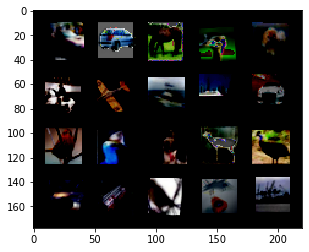

In [ ]:
import matplotlib.pyplot as plt
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

# Visualize train dataset
images_train = next(iter(train_dataloader_C10))[0][:20]
print(len(images_train[3]))
grid_train = torchvision.utils.make_grid(images_train, nrow=5, padding=10)
show(grid_train)

# The preprocessing step of the AugMix method causes problems and images are not
# displayed anymore for the train dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


20


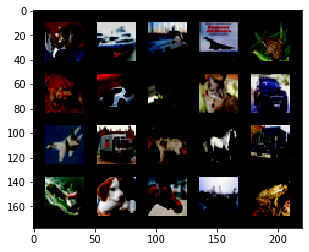

In [ ]:
# Visualize test dataset
images_test = next(iter(test_dataloader_C10))[0][:20]
print(len(images_test))
grid_test = torchvision.utils.make_grid(images_test, nrow=5, padding=10)
show(grid_test)

Visualizing CIFAR-100 data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3


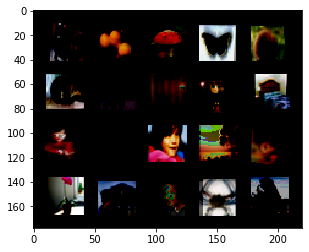

In [ ]:
# Visualize train dataset
images_train = next(iter(train_dataloader_C100))[0][:20]
print(len(images_train[3]))
grid_train = torchvision.utils.make_grid(images_train, nrow=5, padding=10)
show(grid_train)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


20


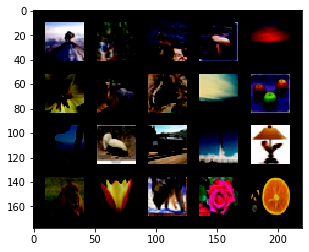

In [ ]:
# Visualize test dataset
images_test = next(iter(test_dataloader_C100))[0][:20]
print(len(images_test))
grid_test = torchvision.utils.make_grid(images_test, nrow=5, padding=10)
show(grid_test)

***
CIFAR-10-C and CIFAR-100-C

To test the corruptions on the CIFAR-10 dataset, this dataset is only used as the testing set, training still occurs on regular CIFAR-10

In [ ]:
from torchvision.datasets.utils import download_and_extract_archive

url = 'https://zenodo.org/record/2535967/files/CIFAR-10-C.tar'
filename = 'CIFAR-10-C.tar'
root = './data/'

download_and_extract_archive(url, root, filename)

  0%|          | 0/2918471680 [00:00<?, ?it/s]

Extracting ./data/CIFAR-10-C.tar to CIFAR-10-C.tar


In [ ]:
from torchvision.datasets.utils import download_and_extract_archive

url = 'https://zenodo.org/record/3555552/files/CIFAR-100-C.tar'
filename = 'CIFAR-100-C.tar'
root = './data/'

download_and_extract_archive(url, root, filename)

  0%|          | 0/2918473216 [00:00<?, ?it/s]

Extracting ./data/CIFAR-100-C.tar to CIFAR-100-C.tar


In [ ]:
os.listdir('./CIFAR-10-C.tar/CIFAR-10-C/')

['contrast.npy',
 'zoom_blur.npy',
 'defocus_blur.npy',
 'saturate.npy',
 'fog.npy',
 'frost.npy',
 'motion_blur.npy',
 'snow.npy',
 'speckle_noise.npy',
 'spatter.npy',
 'gaussian_noise.npy',
 'jpeg_compression.npy',
 'brightness.npy',
 'gaussian_blur.npy',
 'elastic_transform.npy',
 'labels.npy',
 'pixelate.npy',
 'shot_noise.npy',
 'impulse_noise.npy',
 'glass_blur.npy']

In [ ]:
os.listdir('./CIFAR-100-C.tar/CIFAR-100-C/')

['contrast.npy',
 'zoom_blur.npy',
 'defocus_blur.npy',
 'saturate.npy',
 'fog.npy',
 'frost.npy',
 'motion_blur.npy',
 'snow.npy',
 'speckle_noise.npy',
 'spatter.npy',
 'gaussian_noise.npy',
 'jpeg_compression.npy',
 'brightness.npy',
 'README.txt',
 'gaussian_blur.npy',
 'elastic_transform.npy',
 'labels.npy',
 'pixelate.npy',
 'shot_noise.npy',
 'impulse_noise.npy',
 'glass_blur.npy']

In [ ]:
dataset="cifar10"
model="net"

learning_rate= args['learning-rate']
momentum= args['momentum']
decay= args['decay']
no_epochs= args['epochs']
print_frequency= args['print_freq']

base_c_path = './CIFAR-10-C.tar/CIFAR-10-C/'
base_c_path_100 = './CIFAR-100-C.tar/CIFAR-100-C/'

*Test* and *Train* functions. Note a different test function is needed for testing the corrupted dataset.

In [ ]:
def test(net, test_loader):
  """Evaluate network on given dataset."""
  net.eval()
  total_loss = 0.
  total_correct = 0
  with torch.no_grad():
    for images, targets in test_loader:
      images, targets = images.cuda(), targets.cuda()
      logits = net(images)
      loss = F.cross_entropy(logits, targets)
      pred = logits.data.max(1)[1]
      total_loss += float(loss.data)
      total_correct += pred.eq(targets.data).sum().item()

  return total_loss / len(test_loader.dataset), total_correct / len(
      test_loader.dataset)

In [ ]:
def test_c(net, test_data, base_path):
  """Evaluate network on given corrupted dataset."""
  corruption_accs = []
  for corruption in CORRUPTIONS:
    # Reference to original data is mutated
    test_data.data = np.load(base_path + corruption + '.npy')
    test_data.targets = torch.LongTensor(np.load(base_path + 'labels.npy'))

    test_loader = torch.utils.data.DataLoader(
        test_data,
        batch_size=args['eval_batch_size'],
        shuffle=False,
        num_workers=args['num_workers'],
        pin_memory=True)

    test_loss, test_acc = test(net, test_loader)
    corruption_accs.append(test_acc)
    print('{}\n\tTest Loss {:.3f} | Test Error {:.3f}'.format(
        corruption, test_loss, 100 - 100. * test_acc))

  # return np.mean(corruption_accs)
  return corruption_accs

In [ ]:
#This is the training function. We set no_jsd to 1 to disable the Jensen-Shannon
#Divergence loss term (at the cost of slightly lower performance). 
#We also commented scheduler to decrease the computation load.
def train(net, train_loader, optimizer, scheduler):
  """Train for one epoch."""
  net.train()
  no_jsd=1
  loss_ema = 0.
  for i, (images, targets) in enumerate(train_loader):
    optimizer.zero_grad()

    if no_jsd:
      images = images.cuda()
      targets = targets.cuda()
      logits = net(images)
      loss = F.cross_entropy(logits, targets)
    else:
      images_all = torch.cat(images, 0).cuda()
      targets = targets.cuda()
      logits_all = net(images_all)
      logits_clean, logits_aug1, logits_aug2 = torch.split(
          logits_all, images[0].size(0))

      # Cross-entropy is only computed on clean images
      loss = F.cross_entropy(logits_clean, targets)

      p_clean, p_aug1, p_aug2 = F.softmax(
          logits_clean, dim=1), F.softmax(
              logits_aug1, dim=1), F.softmax(
                  logits_aug2, dim=1)

      # Clamp mixture distribution to avoid exploding KL divergence
      p_mixture = torch.clamp((p_clean + p_aug1 + p_aug2) / 3., 1e-7, 1).log()
      loss += 12 * (F.kl_div(p_mixture, p_clean, reduction='batchmean') +
                    F.kl_div(p_mixture, p_aug1, reduction='batchmean') +
                    F.kl_div(p_mixture, p_aug2, reduction='batchmean')) / 3.

    loss.backward()
    optimizer.step()
    #scheduler.step()
    loss_ema = loss_ema * 0.9 + float(loss) * 0.1
    if i % print_frequency == 0:
      print('Train Loss {:.3f}'.format(loss_ema))

  return loss_ema

In [ ]:
# These functions change the learning rate to find the best one.
def get_lr(step, total_steps, lr_max, lr_min):
  """Compute learning rate according to cosine annealing schedule."""
  return lr_min + (lr_max - lr_min) * 0.5 * (1 +
                                             np.cos(step / total_steps * np.pi))


In [ ]:
#define a path for saving the data
log_path = os.path.join(dataset + '_' + model + '_training_log.csv')
with open(log_path, 'w') as f:
  f.write('epoch,time(s),train_loss,test_loss,test_error(%)\n')

# Testing datasets CIFAR-10-C and CIFAR-100-C with AugMix for different models

Models used to train and test: *DenseNet, ResNeXt, AllConvNet* and *WideResNet*

In [ ]:
!git clone https://github.com/RRENT5/Augx.git

from Augx import DenseNet
from Augx import ResNeXt
from Augx import WideResNet
from Augx import AllConvNet


Cloning into 'Augx'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 28 (delta 7), reused 2 (delta 1), pack-reused 0
Unpacking objects: 100% (28/28), done.


We first try with model ***Densenet***.

In [ ]:
# Generate two nets: one with and one without AugMix

#number of classes for CIFAR-10 is 10
net = DenseNet.densenet(num_classes=10)
net_std = DenseNet.densenet(num_classes=10)

optimizer = torch.optim.SGD(
      net.parameters(),
      learning_rate,
      momentum=momentum,
      weight_decay=decay,
      nesterov=True)
optimizer_std = torch.optim.SGD(
      net_std.parameters(),
      learning_rate,
      momentum=momentum,
      weight_decay=decay,
      nesterov=True)

scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda step: get_lr(  # pylint: disable=g-long-lambda
        step,
        no_epochs * len(train_dataloader_C10),
        1,  # lr_lambda computes multiplicative factor
        1e-6 / learning_rate))
scheduler_std = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda step: get_lr(  # pylint: disable=g-long-lambda
        step,
        no_epochs * len(train_dataloader_C10_std),
        1,  # lr_lambda computes multiplicative factor
        1e-6 / learning_rate))

In [ ]:
# Distribute model across all visible GPUs
import torch.backends.cudnn as cudnn

torch.cuda.is_available()
net = torch.nn.DataParallel(net).cuda()
net_std = torch.nn.DataParallel(net_std).cuda()
cudnn.benchmark = True

Checking clean model gives expected error (around 90% for 10 categories)

In [ ]:
test_loss, test_acc = test(net, test_dataloader_C10)
print('Clean\n\tTest Loss {:.3f} | Test Error {:.2f}'.format(
test_loss, 100 - 100. * test_acc))

scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda step: get_lr(  # pylint: disable=g-long-lambda
        step,
        no_epochs * len(train_dataloader_C10),
        1,  # lr_lambda computes multiplicative factor
        1e-6 / learning_rate))

#define a path for saving the data
log_path = os.path.join(dataset + '_' + model + '_training_log.csv')
with open(log_path, 'w') as f:
  f.write('epoch,time(s),train_loss,test_loss,test_error(%)\n')

Clean
	Test Loss 4.076 | Test Error 90.00



Training and testing for CIFAR10, testing also on CIFAR10-C

In [ ]:
def run_model(net, train_loader, optimizer, scheduler):

    dataset="cifar10"
    model="net"

    # If execution crashes, uncomment the following line to learn more about
    # PyTorch CUDA memory summary
    #print(torch.cuda.memory_summary(device=None, abbreviated=False))

    start_epoch=0
    best_acc = 0
    print('Beginning training from epoch:', start_epoch + 1)

    for epoch in range(start_epoch, no_epochs):
        begin_time = time.time()

        train_loss_ema = train(net, train_loader, optimizer, scheduler)
        test_loss, test_acc = test(net, test_dataloader_C10)

        is_best = test_acc > best_acc
        best_acc = max(test_acc, best_acc)
        checkpoint = {
            'epoch': epoch,
            'dataset': dataset,
            'model': model,
            'state_dict': net.state_dict(),
            'best_acc': best_acc,
            'optimizer': optimizer.state_dict(),
        }

        save_path = os.path.join('checkpoint.pth.tar')
        torch.save(checkpoint, save_path)
        if is_best:
            shutil.copyfile(save_path, os.path.join('model_best.pth.tar'))

        with open(log_path, 'a') as f:
            f.write('%03d,%05d,%0.6f,%0.5f,%0.2f\n' % (
                (epoch + 1),
                time.time() - begin_time,
                train_loss_ema,
                test_loss,
                100 - 100. * test_acc,
            ))

        print(
            'Epoch {0:3d} | Time {1:5d} | Train Loss {2:.4f} | Test Loss {3:.3f} |'
            ' Test Error {4:.2f}'
            .format((epoch + 1), int(time.time() - begin_time), train_loss_ema,
                    test_loss, 100 - 100. * test_acc))

In [ ]:
run_model(net, train_dataloader_C10, optimizer, scheduler)

Beginning training from epoch: 1
Train Loss 0.232
Train Loss 1.701
Train Loss 1.465


KeyboardInterrupt: ignored

In [ ]:
# With AugMix
test_loss, test_acc = test(net, test_dataloader_C10)
print('Clean\n\tTest Loss {:.3f} | Test Error {:.2f}'.format(test_loss, 100 - 100. * test_acc))

test_c_accs = test_c(net, test_dataset_C10, base_c_path)
test_c_acc = np.mean(test_c_accs)
print('Mean Corruption Error: {:.3f}'.format(100 - 100. * test_c_acc))

In [ ]:
run_model(net_std, train_dataloader_C10_std, optimizer_std, scheduler_std)

In [ ]:
# Without AugMix
test_loss_std, test_acc_std = test(net_std, test_dataloader_C10)
print('Clean\n\tTest Loss {:.3f} | Test Error {:.2f}'.format(test_loss_std, 100 - 100. * test_acc_std))

test_c_accs_std = test_c(net_std, test_dataset_C10, base_c_path)
test_c_acc_std = np.mean(test_c_accs_std)
print('Mean Corruption Error: {:.3f}'.format(100 - 100. * test_c_acc))

In [ ]:
# TODO: the net has to be adapted for the standard and AugMix applications

test_c_errs = np.subtract(1,test_c_accs) *100
test_c_errs_std = np.subtract(1,test_c_accs_std) *100
test_err_std = np.subtract(1,test_acc) *100

fig = plt.figure(figsize=(10,4))
ax = fig.add_axes([0,0,1,1])
labels = ['Gaussian Noise','Shot Noise','Impulse Noise','Defocus Blur',
          'Glass Blur','Motion Blur','Zoom Blur','Snow','Frost','Fog',
          'Brightness','Contrast','Elastic Transform','Pixelate',
          'JPEG Compression']
x_axis = np.arange(len(labels))
w = 0.2

ax.yaxis.grid(zorder=0)

plt.bar(x_axis-w, test_c_errs_std, w*2, label='Standard', zorder=3)
plt.bar(x_axis+w, test_c_errs, w*2, label='AugMix', zorder=3)

plt.xticks(x_axis,labels,rotation=90)
plt.title('CIFAR-10-C Error Rates for Each Corruption: Densenet')
plt.ylabel('Error (%)')

plt.axhline(y=test_err_std, linewidth=2, color='r', linestyle='--', label='Standard Clean Error', zorder=4)
plt.legend()

plt.savefig('corruptions.eps', format='eps', bbox_inches='tight')

CIFAR100-C

In [ ]:
dataset="cifar100"
model="net"

In [ ]:
#number of classes for CIFAR-100 is 100
net = DenseNet.densenet(num_classes=100)

# Distribute model across all visible GPUs
import torch.backends.cudnn as cudnn
torch.cuda.is_available()
net = torch.nn.DataParallel(net).cuda()
cudnn.benchmark = True

Checking clean model gives expected error (around 99% for 100 categories)

In [ ]:
test_loss, test_acc = test(net, test_dataloader_C100)
print('Clean\n\tTest Loss {:.3f} | Test Error {:.2f}'.format(
test_loss, 100 - 100. * test_acc))

scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda step: get_lr(  # pylint: disable=g-long-lambda
        step,
        no_epochs * len(train_dataloader_C100),
        1,  # lr_lambda computes multiplicative factor
        1e-6 / learning_rate))

#define a path for saving the data
log_path = os.path.join(dataset + '_' + model + '_training_log.csv')
with open(log_path, 'w') as f:
  f.write('epoch,time(s),train_loss,test_loss,test_error(%)\n')

Training and testing for CIFAR100, testing also on CIFAR100-C

In [ ]:
# If execution crashes, uncomment the following line to learn more about
# PyTorch CUDA memory summary

# print(torch.cuda.memory_summary(device=None, abbreviated=False))

start_epoch=0
best_acc = 0
print('Beginning training from epoch:', start_epoch + 1)

for epoch in range(start_epoch, no_epochs):
    begin_time = time.time()

    train_loss_ema = train(net, train_dataloader_C100, optimizer, scheduler)
    test_loss, test_acc = test(net, test_dataloader_C100)

    is_best = test_acc > best_acc
    best_acc = max(test_acc, best_acc)
    checkpoint = {
        'epoch': epoch,
        'dataset': dataset,
        'model': model,
        'state_dict': net.state_dict(),
        'best_acc': best_acc,
        'optimizer': optimizer.state_dict(),
    }

    save_path = os.path.join('checkpoint.pth.tar')
    torch.save(checkpoint, save_path)
    if is_best:
      shutil.copyfile(save_path, os.path.join('model_best.pth.tar'))

    with open(log_path, 'a') as f:
      f.write('%03d,%05d,%0.6f,%0.5f,%0.2f\n' % (
          (epoch + 1),
          time.time() - begin_time,
          train_loss_ema,
          test_loss,
          100 - 100. * test_acc,
      ))

    print(
        'Epoch {0:3d} | Time {1:5d} | Train Loss {2:.4f} | Test Loss {3:.3f} |'
        ' Test Error {4:.2f}'
        .format((epoch + 1), int(time.time() - begin_time), train_loss_ema,
                test_loss, 100 - 100. * test_acc))

In [ ]:
test_loss, test_acc = test(net, test_dataloader_C100)
print('Clean\n\tTest Loss {:.3f} | Test Error {:.2f}'.format(test_loss, 100 - 100. * test_acc))

test_c_accs = test_c(net, test_dataset_C100, base_c_path_100)
test_c_acc = np.mean(test_c_accs)
print('Mean Corruption Error: {:.3f}'.format(100 - 100. * test_c_acc))

Now we try with model ***ResNeXt***. 

In [ ]:
dataset="cifar10"
model="net"

#number of classes for CIFAR-10 is 10
net = ResNeXt.resnext29(num_classes=10)

optimizer = torch.optim.SGD(
      net.parameters(),
      learning_rate,
      momentum=momentum,
      weight_decay=decay,
      nesterov=True)


# Distribute model across all visible GPUs
import torch.backends.cudnn as cudnn
torch.cuda.is_available()
net = torch.nn.DataParallel(net).cuda()
cudnn.benchmark = True

Checking clean model gives expected error (around 90% for 10 categories)

In [ ]:
test_loss, test_acc = test(net, test_dataloader_C10)
print('Clean\n\tTest Loss {:.3f} | Test Error {:.2f}'.format(
test_loss, 100 - 100. * test_acc))

scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda step: get_lr(  # pylint: disable=g-long-lambda
        step,
        no_epochs * len(train_dataloader_C10),
        1,  # lr_lambda computes multiplicative factor
        1e-6 / learning_rate))

#define a path for saving the data
log_path = os.path.join(dataset + '_' + model + '_training_log.csv')
with open(log_path, 'w') as f:
  f.write('epoch,time(s),train_loss,test_loss,test_error(%)\n')

Training and testing for CIFAR10, testing also on CIFAR10-C

In [ ]:
# If execution crashes, uncomment the following line to learn more about
# PyTorch CUDA memory summary

# print(torch.cuda.memory_summary(device=None, abbreviated=False))

start_epoch=0
best_acc = 0
print('Beginning training from epoch:', start_epoch + 1)

for epoch in range(start_epoch, no_epochs):
    begin_time = time.time()

    train_loss_ema = train(net, train_dataloader_C10, optimizer, scheduler)
    test_loss, test_acc = test(net, test_dataloader_C10)

    is_best = test_acc > best_acc
    best_acc = max(test_acc, best_acc)
    checkpoint = {
        'epoch': epoch,
        'dataset': dataset,
        'model': model,
        'state_dict': net.state_dict(),
        'best_acc': best_acc,
        'optimizer': optimizer.state_dict(),
    }

    save_path = os.path.join('checkpoint.pth.tar')
    torch.save(checkpoint, save_path)
    if is_best:
      shutil.copyfile(save_path, os.path.join('model_best.pth.tar'))

    with open(log_path, 'a') as f:
      f.write('%03d,%05d,%0.6f,%0.5f,%0.2f\n' % (
          (epoch + 1),
          time.time() - begin_time,
          train_loss_ema,
          test_loss,
          100 - 100. * test_acc,
      ))

    print(
        'Epoch {0:3d} | Time {1:5d} | Train Loss {2:.4f} | Test Loss {3:.3f} |'
        ' Test Error {4:.2f}'
        .format((epoch + 1), int(time.time() - begin_time), train_loss_ema,
                test_loss, 100 - 100. * test_acc))

In [ ]:
test_loss, test_acc = test(net, test_dataloader_C10)
print('Clean\n\tTest Loss {:.3f} | Test Error {:.2f}'.format(test_loss, 100 - 100. * test_acc))

test_c_accs = test_c(net, test_dataset_C10, base_c_path)
test_c_acc = np.mean(test_c_accs)
print('Mean Corruption Error: {:.3f}'.format(100 - 100. * test_c_acc))

CIFAR100-C

In [ ]:
dataset="cifar100"
model="net"

In [ ]:
#number of classes for CIFAR-100 is 100
net = ResNeXt.resnext29(num_classes=100)

# Distribute model across all visible GPUs
import torch.backends.cudnn as cudnn
torch.cuda.is_available()
net = torch.nn.DataParallel(net).cuda()
cudnn.benchmark = True

Checking clean model gives expected error (around 99% for 100 categories)

In [ ]:
test_loss, test_acc = test(net, test_dataloader_C100)
print('Clean\n\tTest Loss {:.3f} | Test Error {:.2f}'.format(
test_loss, 100 - 100. * test_acc))

scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda step: get_lr(  # pylint: disable=g-long-lambda
        step,
        no_epochs * len(train_dataloader_C100),
        1,  # lr_lambda computes multiplicative factor
        1e-6 / learning_rate))

#define a path for saving the data
log_path = os.path.join(dataset + '_' + model + '_training_log.csv')
with open(log_path, 'w') as f:
  f.write('epoch,time(s),train_loss,test_loss,test_error(%)\n')

Training and testing for CIFAR100, testing also on CIFAR100-C

In [ ]:
# If execution crashes, uncomment the following line to learn more about
# PyTorch CUDA memory summary

# print(torch.cuda.memory_summary(device=None, abbreviated=False))

start_epoch=0
best_acc = 0
print('Beginning training from epoch:', start_epoch + 1)

for epoch in range(start_epoch, no_epochs):
    begin_time = time.time()

    train_loss_ema = train(net, train_dataloader_C100, optimizer, scheduler)
    test_loss, test_acc = test(net, test_dataloader_C100)

    is_best = test_acc > best_acc
    best_acc = max(test_acc, best_acc)
    checkpoint = {
        'epoch': epoch,
        'dataset': dataset,
        'model': model,
        'state_dict': net.state_dict(),
        'best_acc': best_acc,
        'optimizer': optimizer.state_dict(),
    }

    save_path = os.path.join('checkpoint.pth.tar')
    torch.save(checkpoint, save_path)
    if is_best:
      shutil.copyfile(save_path, os.path.join('model_best.pth.tar'))

    with open(log_path, 'a') as f:
      f.write('%03d,%05d,%0.6f,%0.5f,%0.2f\n' % (
          (epoch + 1),
          time.time() - begin_time,
          train_loss_ema,
          test_loss,
          100 - 100. * test_acc,
      ))

    print(
        'Epoch {0:3d} | Time {1:5d} | Train Loss {2:.4f} | Test Loss {3:.3f} |'
        ' Test Error {4:.2f}'
        .format((epoch + 1), int(time.time() - begin_time), train_loss_ema,
                test_loss, 100 - 100. * test_acc))

In [ ]:
test_loss, test_acc = test(net, test_dataloader_C100)
print('Clean\n\tTest Loss {:.3f} | Test Error {:.2f}'.format(test_loss, 100 - 100. * test_acc))

test_c_accs = test_c(net, test_dataset_C100, base_c_path_100)
test_c_acc = np.mean(test_c_accs)
print('Mean Corruption Error: {:.3f}'.format(100 - 100. * test_c_acc))

Now we try with model ***AllConvNet***. 

In [ ]:
dataset="cifar10"
model="net"

#number of classes for CIFAR-10 is 10
net = AllConvNet.AllConvNet(num_classes=10)

optimizer = torch.optim.SGD(
      net.parameters(),
      learning_rate,
      momentum=momentum,
      weight_decay=decay,
      nesterov=True)


# Distribute model across all visible GPUs
import torch.backends.cudnn as cudnn
torch.cuda.is_available()
net = torch.nn.DataParallel(net).cuda()
cudnn.benchmark = True

Checking clean model gives expected error (around 90% for 10 categories)

In [ ]:
test_loss, test_acc = test(net, test_dataloader_C10)
print('Clean\n\tTest Loss {:.3f} | Test Error {:.2f}'.format(
test_loss, 100 - 100. * test_acc))

scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda step: get_lr(  # pylint: disable=g-long-lambda
        step,
        no_epochs * len(train_dataloader_C10),
        1,  # lr_lambda computes multiplicative factor
        1e-6 / learning_rate))

#define a path for saving the data
log_path = os.path.join(dataset + '_' + model + '_training_log.csv')
with open(log_path, 'w') as f:
  f.write('epoch,time(s),train_loss,test_loss,test_error(%)\n')

Training and testing for CIFAR10, testing also on CIFAR10-C

In [ ]:
# If execution crashes, uncomment the following line to learn more about
# PyTorch CUDA memory summary

# print(torch.cuda.memory_summary(device=None, abbreviated=False))

start_epoch=0
best_acc = 0
print('Beginning training from epoch:', start_epoch + 1)

for epoch in range(start_epoch, no_epochs):
    begin_time = time.time()

    train_loss_ema = train(net, train_dataloader_C10, optimizer, scheduler)
    test_loss, test_acc = test(net, test_dataloader_C10)

    is_best = test_acc > best_acc
    best_acc = max(test_acc, best_acc)
    checkpoint = {
        'epoch': epoch,
        'dataset': dataset,
        'model': model,
        'state_dict': net.state_dict(),
        'best_acc': best_acc,
        'optimizer': optimizer.state_dict(),
    }

    save_path = os.path.join('checkpoint.pth.tar')
    torch.save(checkpoint, save_path)
    if is_best:
      shutil.copyfile(save_path, os.path.join('model_best.pth.tar'))

    with open(log_path, 'a') as f:
      f.write('%03d,%05d,%0.6f,%0.5f,%0.2f\n' % (
          (epoch + 1),
          time.time() - begin_time,
          train_loss_ema,
          test_loss,
          100 - 100. * test_acc,
      ))

    print(
        'Epoch {0:3d} | Time {1:5d} | Train Loss {2:.4f} | Test Loss {3:.3f} |'
        ' Test Error {4:.2f}'
        .format((epoch + 1), int(time.time() - begin_time), train_loss_ema,
                test_loss, 100 - 100. * test_acc))

In [ ]:
test_loss, test_acc = test(net, test_dataloader_C10)
print('Clean\n\tTest Loss {:.3f} | Test Error {:.2f}'.format(test_loss, 100 - 100. * test_acc))

test_c_accs = test_c(net, test_dataset_C10, base_c_path)
test_c_acc = np.mean(test_c_accs)
print('Mean Corruption Error: {:.3f}'.format(100 - 100. * test_c_acc))

Training and testing for CIFAR100, testing also on CIFAR100-C

In [ ]:
dataset="cifar100"
model="net"

In [ ]:
#number of classes for CIFAR-100 is 100
net = AllConvNet.AllConvNet(num_classes=100)

# Distribute model across all visible GPUs
import torch.backends.cudnn as cudnn
torch.cuda.is_available()
net = torch.nn.DataParallel(net).cuda()
cudnn.benchmark = True

Checking clean model gives expected error (around 99% for 100 categories)

In [ ]:
test_loss, test_acc = test(net, test_dataloader_C100)
print('Clean\n\tTest Loss {:.3f} | Test Error {:.2f}'.format(
test_loss, 100 - 100. * test_acc))

scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda step: get_lr(  # pylint: disable=g-long-lambda
        step,
        no_epochs * len(train_dataloader_C100),
        1,  # lr_lambda computes multiplicative factor
        1e-6 / learning_rate))

#define a path for saving the data
log_path = os.path.join(dataset + '_' + model + '_training_log.csv')
with open(log_path, 'w') as f:
  f.write('epoch,time(s),train_loss,test_loss,test_error(%)\n')

Training and testing for CIFAR100, testing also on CIFAR100-C

In [ ]:
# If execution crashes, uncomment the following line to learn more about
# PyTorch CUDA memory summary

# print(torch.cuda.memory_summary(device=None, abbreviated=False))

start_epoch=0
best_acc = 0
print('Beginning training from epoch:', start_epoch + 1)

for epoch in range(start_epoch, no_epochs):
    begin_time = time.time()

    train_loss_ema = train(net, train_dataloader_C100, optimizer, scheduler)
    test_loss, test_acc = test(net, test_dataloader_C100)

    is_best = test_acc > best_acc
    best_acc = max(test_acc, best_acc)
    checkpoint = {
        'epoch': epoch,
        'dataset': dataset,
        'model': model,
        'state_dict': net.state_dict(),
        'best_acc': best_acc,
        'optimizer': optimizer.state_dict(),
    }

    save_path = os.path.join('checkpoint.pth.tar')
    torch.save(checkpoint, save_path)
    if is_best:
      shutil.copyfile(save_path, os.path.join('model_best.pth.tar'))

    with open(log_path, 'a') as f:
      f.write('%03d,%05d,%0.6f,%0.5f,%0.2f\n' % (
          (epoch + 1),
          time.time() - begin_time,
          train_loss_ema,
          test_loss,
          100 - 100. * test_acc,
      ))

    print(
        'Epoch {0:3d} | Time {1:5d} | Train Loss {2:.4f} | Test Loss {3:.3f} |'
        ' Test Error {4:.2f}'
        .format((epoch + 1), int(time.time() - begin_time), train_loss_ema,
                test_loss, 100 - 100. * test_acc))

In [ ]:
test_loss, test_acc = test(net, test_dataloader_C100)
print('Clean\n\tTest Loss {:.3f} | Test Error {:.2f}'.format(test_loss, 100 - 100. * test_acc))

test_c_accs = test_c(net, test_dataset_C100, base_c_path_100)
test_c_acc = np.mean(test_c_accs)
print('Mean Corruption Error: {:.3f}'.format(100 - 100. * test_c_acc))

Finally, we try with model ***WideResNet***. 

In [ ]:
dataset="cifar10"
model="net"
depth = args['layers']

#number of classes for CIFAR-10 is 10
net = WideResNet.WideResNet(depth=depth, num_classes=10)

optimizer = torch.optim.SGD(
      net.parameters(),
      learning_rate,
      momentum=momentum,
      weight_decay=decay,
      nesterov=True)


# Distribute model across all visible GPUs
import torch.backends.cudnn as cudnn
torch.cuda.is_available()
net = torch.nn.DataParallel(net).cuda()
cudnn.benchmark = True

Checking clean model gives expected error (around 90% for 10 categories)

In [ ]:
test_loss, test_acc = test(net, test_dataloader_C10)
print('Clean\n\tTest Loss {:.3f} | Test Error {:.2f}'.format(
test_loss, 100 - 100. * test_acc))

scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda step: get_lr(  # pylint: disable=g-long-lambda
        step,
        no_epochs * len(train_dataloader_C10),
        1,  # lr_lambda computes multiplicative factor
        1e-6 / learning_rate))

#define a path for saving the data
log_path = os.path.join(dataset + '_' + model + '_training_log.csv')
with open(log_path, 'w') as f:
  f.write('epoch,time(s),train_loss,test_loss,test_error(%)\n')

Training and testing for CIFAR10, testing also on CIFAR10-C

In [ ]:
dataset="cifar10"
model="net"

# If execution crashes, uncomment the following line to learn more about
# PyTorch CUDA memory summary
#print(torch.cuda.memory_summary(device=None, abbreviated=False))

start_epoch=0
best_acc = 0
print('Beginning training from epoch:', start_epoch + 1)

for epoch in range(start_epoch, no_epochs):
    begin_time = time.time()

    train_loss_ema = train(net, train_dataloader_C10, optimizer, scheduler)
    test_loss, test_acc = test(net, test_dataloader_C10)

    is_best = test_acc > best_acc
    best_acc = max(test_acc, best_acc)
    checkpoint = {
        'epoch': epoch,
        'dataset': dataset,
        'model': model,
        'state_dict': net.state_dict(),
        'best_acc': best_acc,
        'optimizer': optimizer.state_dict(),
    }

    save_path = os.path.join('checkpoint.pth.tar')
    torch.save(checkpoint, save_path)
    if is_best:
      shutil.copyfile(save_path, os.path.join('model_best.pth.tar'))

    with open(log_path, 'a') as f:
      f.write('%03d,%05d,%0.6f,%0.5f,%0.2f\n' % (
          (epoch + 1),
          time.time() - begin_time,
          train_loss_ema,
          test_loss,
          100 - 100. * test_acc,
      ))

    print(
        'Epoch {0:3d} | Time {1:5d} | Train Loss {2:.4f} | Test Loss {3:.3f} |'
        ' Test Error {4:.2f}'
        .format((epoch + 1), int(time.time() - begin_time), train_loss_ema,
                test_loss, 100 - 100. * test_acc))

In [ ]:
test_loss, test_acc = test(net, test_dataloader_C10)
print('Clean\n\tTest Loss {:.3f} | Test Error {:.2f}'.format(test_loss, 100 - 100. * test_acc))

test_c_accs = test_c(net, test_dataset_C10, base_c_path)
test_c_acc = np.mean(test_c_accs)
print('Mean Corruption Error: {:.3f}'.format(100 - 100. * test_c_acc))

Training and testing for CIFAR100, testing also on CIFAR100-C

In [ ]:
dataset="cifar100"
model="net"

In [ ]:
#number of classes for CIFAR-100 is 100
net = WideResNet.WideResNet(depth=depth, num_classes=10)

# Distribute model across all visible GPUs
import torch.backends.cudnn as cudnn
torch.cuda.is_available()
net = torch.nn.DataParallel(net).cuda()
cudnn.benchmark = True

Checking clean model gives expected error (around 99% for 100 categories)

In [ ]:
test_loss, test_acc = test(net, test_dataloader_C100)
print('Clean\n\tTest Loss {:.3f} | Test Error {:.2f}'.format(
test_loss, 100 - 100. * test_acc))

scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda step: get_lr(  # pylint: disable=g-long-lambda
        step,
        no_epochs * len(train_dataloader_C100),
        1,  # lr_lambda computes multiplicative factor
        1e-6 / learning_rate))

#define a path for saving the data
log_path = os.path.join(dataset + '_' + model + '_training_log.csv')
with open(log_path, 'w') as f:
  f.write('epoch,time(s),train_loss,test_loss,test_error(%)\n')

In [ ]:
# If execution crashes, uncomment the following line to learn more about
# PyTorch CUDA memory summary

# print(torch.cuda.memory_summary(device=None, abbreviated=False))

start_epoch=0
best_acc = 0
print('Beginning training from epoch:', start_epoch + 1)

for epoch in range(start_epoch, no_epochs):
    begin_time = time.time()

    train_loss_ema = train(net, train_dataloader_C100, optimizer, scheduler)
    test_loss, test_acc = test(net, test_dataloader_C100)

    is_best = test_acc > best_acc
    best_acc = max(test_acc, best_acc)
    checkpoint = {
        'epoch': epoch,
        'dataset': dataset,
        'model': model,
        'state_dict': net.state_dict(),
        'best_acc': best_acc,
        'optimizer': optimizer.state_dict(),
    }

    save_path = os.path.join('checkpoint.pth.tar')
    torch.save(checkpoint, save_path)
    if is_best:
      shutil.copyfile(save_path, os.path.join('model_best.pth.tar'))

    with open(log_path, 'a') as f:
      f.write('%03d,%05d,%0.6f,%0.5f,%0.2f\n' % (
          (epoch + 1),
          time.time() - begin_time,
          train_loss_ema,
          test_loss,
          100 - 100. * test_acc,
      ))

    print(
        'Epoch {0:3d} | Time {1:5d} | Train Loss {2:.4f} | Test Loss {3:.3f} |'
        ' Test Error {4:.2f}'
        .format((epoch + 1), int(time.time() - begin_time), train_loss_ema,
                test_loss, 100 - 100. * test_acc))

In [ ]:
test_loss, test_acc = test(net, test_dataloader_C100)
print('Clean\n\tTest Loss {:.3f} | Test Error {:.2f}'.format(test_loss, 100 - 100. * test_acc))

test_c_accs = test_c(net, test_dataset_C100, base_c_path_100)
test_c_acc = np.mean(test_c_accs)
print('Mean Corruption Error: {:.3f}'.format(100 - 100. * test_c_acc))

# A pointless extension

In [ ]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [ ]:
#This is the training function. We set no_jsd to 1 to disable the Jensen-Shannon
#Divergence loss term (at the cost of slightly lower performance). 
#We also commented scheduler to decrease the computation load.
def train(net, train_loader, optimizer, scheduler):
  """Train for one epoch."""
  net.train()
  no_jsd=1
  loss_ema = 0.
  for i, (images, targets) in enumerate(train_loader):
    optimizer.zero_grad()

    if no_jsd:
      images = images.cuda()
      targets = targets.cuda()
      r = np.random.rand(1)
      if  r < 0.5:
            lam = np.random.beta(1, 0.1)
            rand_index = torch.randperm(images.size()[0]).cuda()
            target_a = targets
            target_b = targets[rand_index]
            bbx1, bby1, bbx2, bby2 = rand_bbox(images.size(), lam)
            images[:, :, bbx1:bbx2, bby1:bby2] = images[rand_index, :, bbx1:bbx2, bby1:bby2] 
      logits = net(images)
      loss = F.cross_entropy(logits, targets)
    else:
      images_all = torch.cat(images, 0).cuda()
      targets = targets.cuda()
      logits_all = net(images_all)
      logits_clean, logits_aug1, logits_aug2 = torch.split(
          logits_all, images[0].size(0))

      # Cross-entropy is only computed on clean images
      loss = F.cross_entropy(logits_clean, targets)

      p_clean, p_aug1, p_aug2 = F.softmax(
          logits_clean, dim=1), F.softmax(
              logits_aug1, dim=1), F.softmax(
                  logits_aug2, dim=1)

      # Clamp mixture distribution to avoid exploding KL divergence
      p_mixture = torch.clamp((p_clean + p_aug1 + p_aug2) / 3., 1e-7, 1).log()
      loss += 12 * (F.kl_div(p_mixture, p_clean, reduction='batchmean') +
                    F.kl_div(p_mixture, p_aug1, reduction='batchmean') +
                    F.kl_div(p_mixture, p_aug2, reduction='batchmean')) / 3.

    loss.backward()
    optimizer.step()
    scheduler.step()
    loss_ema = loss_ema * 0.9 + float(loss) * 0.1
    if i % print_frequency == 0:
      print('Train Loss {:.3f}'.format(loss_ema))

  return loss_ema

In [ ]:
def run_model(net, train_loader, optimizer, scheduler):

    dataset="cifar10"
    model="net"

    # If execution crashes, uncomment the following line to learn more about
    # PyTorch CUDA memory summary
    #print(torch.cuda.memory_summary(device=None, abbreviated=False))

    start_epoch=0
    best_acc = 0
    print('Beginning training from epoch:', start_epoch + 1)

    for epoch in range(start_epoch, no_epochs):
        begin_time = time.time()

        train_loss_ema = train(net, train_loader, optimizer, scheduler)
        test_loss, test_acc = test(net, test_dataloader_C10)

        is_best = test_acc > best_acc
        best_acc = max(test_acc, best_acc)
        checkpoint = {
            'epoch': epoch,
            'dataset': dataset,
            'model': model,
            'state_dict': net.state_dict(),
            'best_acc': best_acc,
            'optimizer': optimizer.state_dict(),
        }

        save_path = os.path.join('checkpoint.pth.tar')
        torch.save(checkpoint, save_path)
        if is_best:
            shutil.copyfile(save_path, os.path.join('model_best.pth.tar'))

        with open(log_path, 'a') as f:
            f.write('%03d,%05d,%0.6f,%0.5f,%0.2f\n' % (
                (epoch + 1),
                time.time() - begin_time,
                train_loss_ema,
                test_loss,
                100 - 100. * test_acc,
            ))

        print(
            'Epoch {0:3d} | Time {1:5d} | Train Loss {2:.4f} | Test Loss {3:.3f} |'
            ' Test Error {4:.2f}'
            .format((epoch + 1), int(time.time() - begin_time), train_loss_ema,
                    test_loss, 100 - 100. * test_acc))

In [ ]:
# With AugMix
test_loss, test_acc = test(net, test_dataloader_C10)
print('Clean\n\tTest Loss {:.3f} | Test Error {:.2f}'.format(test_loss, 100 - 100. * test_acc))

test_c_accs = test_c(net, test_dataset_C10, base_c_path)
test_c_acc = np.mean(test_c_accs)
print('Mean Corruption Error: {:.3f}'.format(100 - 100. * test_c_acc))

Clean
	Test Loss 0.002 | Test Error 52.85
gaussian_noise
	Test Loss 0.002 | Test Error 57.990
shot_noise
	Test Loss 0.002 | Test Error 56.376
impulse_noise
	Test Loss 0.002 | Test Error 60.646
defocus_blur
	Test Loss 0.002 | Test Error 54.286
glass_blur
	Test Loss 0.002 | Test Error 56.248
motion_blur
	Test Loss 0.002 | Test Error 54.882
zoom_blur
	Test Loss 0.002 | Test Error 55.048
snow
	Test Loss 0.002 | Test Error 62.972
frost
	Test Loss 0.002 | Test Error 62.752
fog
	Test Loss 0.002 | Test Error 63.178
brightness
	Test Loss 0.002 | Test Error 58.278
contrast
	Test Loss 0.003 | Test Error 70.394
elastic_transform
	Test Loss 0.002 | Test Error 54.756
pixelate
	Test Loss 0.002 | Test Error 54.872
jpeg_compression
	Test Loss 0.002 | Test Error 54.466
Mean Corruption Error: 58.476


In [ ]:
run_model(net_std, train_dataloader_C10_std, optimizer_std, scheduler_std)

Beginning training from epoch: 1
Train Loss 0.232
Epoch   1 | Time    44 | Train Loss 1.6249 | Test Loss 0.002 | Test Error 73.25
Train Loss 0.197
Epoch   2 | Time    42 | Train Loss 1.3781 | Test Loss 0.002 | Test Error 58.00
Train Loss 0.149
Epoch   3 | Time    43 | Train Loss 1.3830 | Test Loss 0.002 | Test Error 62.78
Train Loss 0.157
Epoch   4 | Time    42 | Train Loss 1.1223 | Test Loss 0.003 | Test Error 66.63
Train Loss 0.161
Epoch   5 | Time    42 | Train Loss 1.0226 | Test Loss 0.002 | Test Error 58.37


In [ ]:
# Without AugMix
test_loss_std, test_acc_std = test(net_std, test_dataloader_C10)
print('Clean\n\tTest Loss {:.3f} | Test Error {:.2f}'.format(test_loss_std, 100 - 100. * test_acc_std))

test_c_accs_std = test_c(net_std, test_dataset_C10, base_c_path)
test_c_acc_std = np.mean(test_c_accs_std)
print('Mean Corruption Error: {:.3f}'.format(100 - 100. * test_c_acc))

Clean
	Test Loss 0.002 | Test Error 58.37
gaussian_noise
	Test Loss 0.002 | Test Error 65.828
shot_noise
	Test Loss 0.002 | Test Error 62.070
impulse_noise
	Test Loss 0.003 | Test Error 67.944
defocus_blur
	Test Loss 0.002 | Test Error 67.170
glass_blur
	Test Loss 0.002 | Test Error 64.764
motion_blur
	Test Loss 0.003 | Test Error 78.096
zoom_blur
	Test Loss 0.003 | Test Error 73.664
snow
	Test Loss 0.002 | Test Error 63.368
frost
	Test Loss 0.002 | Test Error 61.916
fog
	Test Loss 0.002 | Test Error 67.030
brightness
	Test Loss 0.002 | Test Error 58.282
contrast
	Test Loss 0.003 | Test Error 73.734
elastic_transform
	Test Loss 0.002 | Test Error 68.222
pixelate
	Test Loss 0.002 | Test Error 52.152
jpeg_compression
	Test Loss 0.002 | Test Error 58.374
Mean Corruption Error: 58.476


NameError: ignored

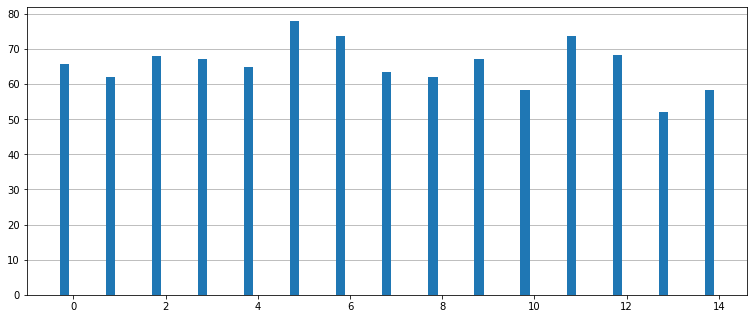

In [ ]:
# TODO: the net has to be adapted for the standard and AugMix applications

test_c_errs_Gutmix = np.subtract(1,test_c_accs) *100
test_c_errs_std = np.subtract(1,test_c_accs_std) *100
test_err_std = np.subtract(1,test_acc) *100

fig = plt.figure(figsize=(10,4))
ax = fig.add_axes([0,0,1,1])
labels = ['Gaussian Noise','Shot Noise','Impulse Noise','Defocus Blur',
          'Glass Blur','Motion Blur','Zoom Blur','Snow','Frost','Fog',
          'Brightness','Contrast','Elastic Transform','Pixelate',
          'JPEG Compression']
x_axis = np.arange(len(labels))
w = 0.1

ax.yaxis.grid(zorder=0)

plt.bar(x_axis-2*w, test_c_errs_std, w*2, label='Standard', zorder=3)
plt.bar(x_axis, test_c_errs, w*2, label='AugMix', zorder=3)
plt.bar(x_axis+2*w, test_c_errs_Gutmix, w*2, label='GutMix', zorder=3)

plt.xticks(x_axis,labels,rotation=90)
plt.title('CIFAR-10-C Error Rates for Each Corruption: Densenet')
plt.ylabel('Error (%)')

plt.axhline(y=test_err_std, linewidth=2, color='r', linestyle='--', label='Standard Clean Error', zorder=4)
plt.legend()

plt.savefig('corruptions.eps', format='eps', bbox_inches='tight')

In [ ]:
dataset="cifar100"
model="net"

In [ ]:
#number of classes for CIFAR-100 is 100
net = DenseNet.densenet(num_classes=100)

# Distribute model across all visible GPUs
import torch.backends.cudnn as cudnn
torch.cuda.is_available()
net = torch.nn.DataParallel(net).cuda()
cudnn.benchmark = True

In [ ]:
test_loss, test_acc = test(net, test_dataloader_C100)
print('Clean\n\tTest Loss {:.3f} | Test Error {:.2f}'.format(
test_loss, 100 - 100. * test_acc))

scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda step: get_lr(  # pylint: disable=g-long-lambda
        step,
        no_epochs * len(train_dataloader_C100),
        1,  # lr_lambda computes multiplicative factor
        1e-6 / learning_rate))

#define a path for saving the data
log_path = os.path.join(dataset + '_' + model + '_training_log.csv')
with open(log_path, 'w') as f:
  f.write('epoch,time(s),train_loss,test_loss,test_error(%)\n')

Clean
	Test Loss 5.228 | Test Error 99.00


In [ ]:
# If execution crashes, uncomment the following line to learn more about
# PyTorch CUDA memory summary

# print(torch.cuda.memory_summary(device=None, abbreviated=False))

start_epoch=0
best_acc = 0
print('Beginning training from epoch:', start_epoch + 1)

for epoch in range(start_epoch, no_epochs):
    begin_time = time.time()

    train_loss_ema = train(net, train_dataloader_C100, optimizer, scheduler)
    test_loss, test_acc = test(net, test_dataloader_C100)

    is_best = test_acc > best_acc
    best_acc = max(test_acc, best_acc)
    checkpoint = {
        'epoch': epoch,
        'dataset': dataset,
        'model': model,
        'state_dict': net.state_dict(),
        'best_acc': best_acc,
        'optimizer': optimizer.state_dict(),
    }

    save_path = os.path.join('checkpoint.pth.tar')
    torch.save(checkpoint, save_path)
    if is_best:
      shutil.copyfile(save_path, os.path.join('model_best.pth.tar'))

    with open(log_path, 'a') as f:
      f.write('%03d,%05d,%0.6f,%0.5f,%0.2f\n' % (
          (epoch + 1),
          time.time() - begin_time,
          train_loss_ema,
          test_loss,
          100 - 100. * test_acc,
      ))

    print(
        'Epoch {0:3d} | Time {1:5d} | Train Loss {2:.4f} | Test Loss {3:.3f} |'
        ' Test Error {4:.2f}'
        .format((epoch + 1), int(time.time() - begin_time), train_loss_ema,
                test_loss, 100 - 100. * test_acc))

In [ ]:
test_loss, test_acc = test(net, test_dataloader_C100)
print('Clean\n\tTest Loss {:.3f} | Test Error {:.2f}'.format(test_loss, 100 - 100. * test_acc))

test_c_accs = test_c(net, test_dataset_C100, base_c_path_100)
test_c_acc = np.mean(test_c_accs)
print('Mean Corruption Error: {:.3f}'.format(100 - 100. * test_c_acc))

In [ ]:
dataset="cifar10"
model="net"

#number of classes for CIFAR-10 is 10
net = ResNeXt.resnext29(num_classes=10)

optimizer = torch.optim.SGD(
      net.parameters(),
      learning_rate,
      momentum=momentum,
      weight_decay=decay,
      nesterov=True)


# Distribute model across all visible GPUs
import torch.backends.cudnn as cudnn
torch.cuda.is_available()
net = torch.nn.DataParallel(net).cuda()
cudnn.benchmark = True

In [ ]:
test_loss, test_acc = test(net, test_dataloader_C10)
print('Clean\n\tTest Loss {:.3f} | Test Error {:.2f}'.format(
test_loss, 100 - 100. * test_acc))

scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda step: get_lr(  # pylint: disable=g-long-lambda
        step,
        no_epochs * len(train_dataloader_C10),
        1,  # lr_lambda computes multiplicative factor
        1e-6 / learning_rate))

#define a path for saving the data
log_path = os.path.join(dataset + '_' + model + '_training_log.csv')
with open(log_path, 'w') as f:
  f.write('epoch,time(s),train_loss,test_loss,test_error(%)\n')

In [ ]:
# If execution crashes, uncomment the following line to learn more about
# PyTorch CUDA memory summary

# print(torch.cuda.memory_summary(device=None, abbreviated=False))

start_epoch=0
best_acc = 0
print('Beginning training from epoch:', start_epoch + 1)

for epoch in range(start_epoch, no_epochs):
    begin_time = time.time()

    train_loss_ema = train(net, train_dataloader_C10, optimizer, scheduler)
    test_loss, test_acc = test(net, test_dataloader_C10)

    is_best = test_acc > best_acc
    best_acc = max(test_acc, best_acc)
    checkpoint = {
        'epoch': epoch,
        'dataset': dataset,
        'model': model,
        'state_dict': net.state_dict(),
        'best_acc': best_acc,
        'optimizer': optimizer.state_dict(),
    }

    save_path = os.path.join('checkpoint.pth.tar')
    torch.save(checkpoint, save_path)
    if is_best:
      shutil.copyfile(save_path, os.path.join('model_best.pth.tar'))

    with open(log_path, 'a') as f:
      f.write('%03d,%05d,%0.6f,%0.5f,%0.2f\n' % (
          (epoch + 1),
          time.time() - begin_time,
          train_loss_ema,
          test_loss,
          100 - 100. * test_acc,
      ))

    print(
        'Epoch {0:3d} | Time {1:5d} | Train Loss {2:.4f} | Test Loss {3:.3f} |'
        ' Test Error {4:.2f}'
        .format((epoch + 1), int(time.time() - begin_time), train_loss_ema,
                test_loss, 100 - 100. * test_acc))

In [ ]:
test_loss, test_acc = test(net, test_dataloader_C10)
print('Clean\n\tTest Loss {:.3f} | Test Error {:.2f}'.format(test_loss, 100 - 100. * test_acc))

test_c_accs = test_c(net, test_dataset_C10, base_c_path)
test_c_acc = np.mean(test_c_accs)
print('Mean Corruption Error: {:.3f}'.format(100 - 100. * test_c_acc))

In [ ]:
dataset="cifar100"
model="net"

In [ ]:
#number of classes for CIFAR-100 is 100
net = ResNeXt.resnext29(num_classes=100)

# Distribute model across all visible GPUs
import torch.backends.cudnn as cudnn
torch.cuda.is_available()
net = torch.nn.DataParallel(net).cuda()
cudnn.benchmark = True

In [ ]:
test_loss, test_acc = test(net, test_dataloader_C100)
print('Clean\n\tTest Loss {:.3f} | Test Error {:.2f}'.format(
test_loss, 100 - 100. * test_acc))

scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda step: get_lr(  # pylint: disable=g-long-lambda
        step,
        no_epochs * len(train_dataloader_C100),
        1,  # lr_lambda computes multiplicative factor
        1e-6 / learning_rate))

#define a path for saving the data
log_path = os.path.join(dataset + '_' + model + '_training_log.csv')
with open(log_path, 'w') as f:
  f.write('epoch,time(s),train_loss,test_loss,test_error(%)\n')

In [ ]:
# If execution crashes, uncomment the following line to learn more about
# PyTorch CUDA memory summary

# print(torch.cuda.memory_summary(device=None, abbreviated=False))

start_epoch=0
best_acc = 0
print('Beginning training from epoch:', start_epoch + 1)

for epoch in range(start_epoch, no_epochs):
    begin_time = time.time()

    train_loss_ema = train(net, train_dataloader_C100, optimizer, scheduler)
    test_loss, test_acc = test(net, test_dataloader_C100)

    is_best = test_acc > best_acc
    best_acc = max(test_acc, best_acc)
    checkpoint = {
        'epoch': epoch,
        'dataset': dataset,
        'model': model,
        'state_dict': net.state_dict(),
        'best_acc': best_acc,
        'optimizer': optimizer.state_dict(),
    }

    save_path = os.path.join('checkpoint.pth.tar')
    torch.save(checkpoint, save_path)
    if is_best:
      shutil.copyfile(save_path, os.path.join('model_best.pth.tar'))

    with open(log_path, 'a') as f:
      f.write('%03d,%05d,%0.6f,%0.5f,%0.2f\n' % (
          (epoch + 1),
          time.time() - begin_time,
          train_loss_ema,
          test_loss,
          100 - 100. * test_acc,
      ))

    print(
        'Epoch {0:3d} | Time {1:5d} | Train Loss {2:.4f} | Test Loss {3:.3f} |'
        ' Test Error {4:.2f}'
        .format((epoch + 1), int(time.time() - begin_time), train_loss_ema,
                test_loss, 100 - 100. * test_acc))

In [ ]:
test_loss, test_acc = test(net, test_dataloader_C100)
print('Clean\n\tTest Loss {:.3f} | Test Error {:.2f}'.format(test_loss, 100 - 100. * test_acc))

test_c_accs = test_c(net, test_dataset_C100, base_c_path_100)
test_c_acc = np.mean(test_c_accs)
print('Mean Corruption Error: {:.3f}'.format(100 - 100. * test_c_acc))

In [ ]:
dataset="cifar10"
model="net"

#number of classes for CIFAR-10 is 10
net = AllConvNet.AllConvNet(num_classes=10)

optimizer = torch.optim.SGD(
      net.parameters(),
      learning_rate,
      momentum=momentum,
      weight_decay=decay,
      nesterov=True)


# Distribute model across all visible GPUs
import torch.backends.cudnn as cudnn
torch.cuda.is_available()
net = torch.nn.DataParallel(net).cuda()
cudnn.benchmark = True

In [ ]:
test_loss, test_acc = test(net, test_dataloader_C10)
print('Clean\n\tTest Loss {:.3f} | Test Error {:.2f}'.format(
test_loss, 100 - 100. * test_acc))

scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda step: get_lr(  # pylint: disable=g-long-lambda
        step,
        no_epochs * len(train_dataloader_C10),
        1,  # lr_lambda computes multiplicative factor
        1e-6 / learning_rate))

#define a path for saving the data
log_path = os.path.join(dataset + '_' + model + '_training_log.csv')
with open(log_path, 'w') as f:
  f.write('epoch,time(s),train_loss,test_loss,test_error(%)\n')

In [ ]:
# If execution crashes, uncomment the following line to learn more about
# PyTorch CUDA memory summary

# print(torch.cuda.memory_summary(device=None, abbreviated=False))

start_epoch=0
best_acc = 0
print('Beginning training from epoch:', start_epoch + 1)

for epoch in range(start_epoch, no_epochs):
    begin_time = time.time()

    train_loss_ema = train(net, train_dataloader_C10, optimizer, scheduler)
    test_loss, test_acc = test(net, test_dataloader_C10)

    is_best = test_acc > best_acc
    best_acc = max(test_acc, best_acc)
    checkpoint = {
        'epoch': epoch,
        'dataset': dataset,
        'model': model,
        'state_dict': net.state_dict(),
        'best_acc': best_acc,
        'optimizer': optimizer.state_dict(),
    }

    save_path = os.path.join('checkpoint.pth.tar')
    torch.save(checkpoint, save_path)
    if is_best:
      shutil.copyfile(save_path, os.path.join('model_best.pth.tar'))

    with open(log_path, 'a') as f:
      f.write('%03d,%05d,%0.6f,%0.5f,%0.2f\n' % (
          (epoch + 1),
          time.time() - begin_time,
          train_loss_ema,
          test_loss,
          100 - 100. * test_acc,
      ))

    print(
        'Epoch {0:3d} | Time {1:5d} | Train Loss {2:.4f} | Test Loss {3:.3f} |'
        ' Test Error {4:.2f}'
        .format((epoch + 1), int(time.time() - begin_time), train_loss_ema,
                test_loss, 100 - 100. * test_acc))

In [ ]:
test_loss, test_acc = test(net, test_dataloader_C10)
print('Clean\n\tTest Loss {:.3f} | Test Error {:.2f}'.format(test_loss, 100 - 100. * test_acc))

test_c_accs = test_c(net, test_dataset_C10, base_c_path)
test_c_acc = np.mean(test_c_accs)
print('Mean Corruption Error: {:.3f}'.format(100 - 100. * test_c_acc))

In [ ]:
dataset="cifar100"
model="net"

In [ ]:
#number of classes for CIFAR-100 is 100
net = AllConvNet.AllConvNet(num_classes=100)

# Distribute model across all visible GPUs
import torch.backends.cudnn as cudnn
torch.cuda.is_available()
net = torch.nn.DataParallel(net).cuda()
cudnn.benchmark = True

In [ ]:
test_loss, test_acc = test(net, test_dataloader_C100)
print('Clean\n\tTest Loss {:.3f} | Test Error {:.2f}'.format(
test_loss, 100 - 100. * test_acc))

scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda step: get_lr(  # pylint: disable=g-long-lambda
        step,
        no_epochs * len(train_dataloader_C100),
        1,  # lr_lambda computes multiplicative factor
        1e-6 / learning_rate))

#define a path for saving the data
log_path = os.path.join(dataset + '_' + model + '_training_log.csv')
with open(log_path, 'w') as f:
  f.write('epoch,time(s),train_loss,test_loss,test_error(%)\n')

In [ ]:
# If execution crashes, uncomment the following line to learn more about
# PyTorch CUDA memory summary

# print(torch.cuda.memory_summary(device=None, abbreviated=False))

start_epoch=0
best_acc = 0
print('Beginning training from epoch:', start_epoch + 1)

for epoch in range(start_epoch, no_epochs):
    begin_time = time.time()

    train_loss_ema = train(net, train_dataloader_C100, optimizer, scheduler)
    test_loss, test_acc = test(net, test_dataloader_C100)

    is_best = test_acc > best_acc
    best_acc = max(test_acc, best_acc)
    checkpoint = {
        'epoch': epoch,
        'dataset': dataset,
        'model': model,
        'state_dict': net.state_dict(),
        'best_acc': best_acc,
        'optimizer': optimizer.state_dict(),
    }

    save_path = os.path.join('checkpoint.pth.tar')
    torch.save(checkpoint, save_path)
    if is_best:
      shutil.copyfile(save_path, os.path.join('model_best.pth.tar'))

    with open(log_path, 'a') as f:
      f.write('%03d,%05d,%0.6f,%0.5f,%0.2f\n' % (
          (epoch + 1),
          time.time() - begin_time,
          train_loss_ema,
          test_loss,
          100 - 100. * test_acc,
      ))

    print(
        'Epoch {0:3d} | Time {1:5d} | Train Loss {2:.4f} | Test Loss {3:.3f} |'
        ' Test Error {4:.2f}'
        .format((epoch + 1), int(time.time() - begin_time), train_loss_ema,
                test_loss, 100 - 100. * test_acc))

In [ ]:
test_loss, test_acc = test(net, test_dataloader_C100)
print('Clean\n\tTest Loss {:.3f} | Test Error {:.2f}'.format(test_loss, 100 - 100. * test_acc))

test_c_accs = test_c(net, test_dataset_C100, base_c_path_100)
test_c_acc = np.mean(test_c_accs)
print('Mean Corruption Error: {:.3f}'.format(100 - 100. * test_c_acc))

In [ ]:
dataset="cifar10"
model="net"
depth = args['layers']

#number of classes for CIFAR-10 is 10
net = WideResNet.WideResNet(depth=depth, num_classes=10)

optimizer = torch.optim.SGD(
      net.parameters(),
      learning_rate,
      momentum=momentum,
      weight_decay=decay,
      nesterov=True)


# Distribute model across all visible GPUs
import torch.backends.cudnn as cudnn
torch.cuda.is_available()
net = torch.nn.DataParallel(net).cuda()
cudnn.benchmark = True

In [ ]:
test_loss, test_acc = test(net, test_dataloader_C10)
print('Clean\n\tTest Loss {:.3f} | Test Error {:.2f}'.format(
test_loss, 100 - 100. * test_acc))

scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda step: get_lr(  # pylint: disable=g-long-lambda
        step,
        no_epochs * len(train_dataloader_C10),
        1,  # lr_lambda computes multiplicative factor
        1e-6 / learning_rate))

#define a path for saving the data
log_path = os.path.join(dataset + '_' + model + '_training_log.csv')
with open(log_path, 'w') as f:
  f.write('epoch,time(s),train_loss,test_loss,test_error(%)\n')

In [ ]:
dataset="cifar10"
model="net"

# If execution crashes, uncomment the following line to learn more about
# PyTorch CUDA memory summary
#print(torch.cuda.memory_summary(device=None, abbreviated=False))

start_epoch=0
best_acc = 0
print('Beginning training from epoch:', start_epoch + 1)

for epoch in range(start_epoch, no_epochs):
    begin_time = time.time()

    train_loss_ema = train(net, train_dataloader_C10, optimizer, scheduler)
    test_loss, test_acc = test(net, test_dataloader_C10)

    is_best = test_acc > best_acc
    best_acc = max(test_acc, best_acc)
    checkpoint = {
        'epoch': epoch,
        'dataset': dataset,
        'model': model,
        'state_dict': net.state_dict(),
        'best_acc': best_acc,
        'optimizer': optimizer.state_dict(),
    }

    save_path = os.path.join('checkpoint.pth.tar')
    torch.save(checkpoint, save_path)
    if is_best:
      shutil.copyfile(save_path, os.path.join('model_best.pth.tar'))

    with open(log_path, 'a') as f:
      f.write('%03d,%05d,%0.6f,%0.5f,%0.2f\n' % (
          (epoch + 1),
          time.time() - begin_time,
          train_loss_ema,
          test_loss,
          100 - 100. * test_acc,
      ))

    print(
        'Epoch {0:3d} | Time {1:5d} | Train Loss {2:.4f} | Test Loss {3:.3f} |'
        ' Test Error {4:.2f}'
        .format((epoch + 1), int(time.time() - begin_time), train_loss_ema,
                test_loss, 100 - 100. * test_acc))

In [ ]:
test_loss, test_acc = test(net, test_dataloader_C10)
print('Clean\n\tTest Loss {:.3f} | Test Error {:.2f}'.format(test_loss, 100 - 100. * test_acc))

test_c_accs = test_c(net, test_dataset_C10, base_c_path)
test_c_acc = np.mean(test_c_accs)
print('Mean Corruption Error: {:.3f}'.format(100 - 100. * test_c_acc))

In [ ]:
dataset="cifar100"
model="net"

In [ ]:
#number of classes for CIFAR-100 is 100
net = WideResNet.WideResNet(depth=depth, num_classes=10)

# Distribute model across all visible GPUs
import torch.backends.cudnn as cudnn
torch.cuda.is_available()
net = torch.nn.DataParallel(net).cuda()
cudnn.benchmark = True

In [ ]:
test_loss, test_acc = test(net, test_dataloader_C100)
print('Clean\n\tTest Loss {:.3f} | Test Error {:.2f}'.format(
test_loss, 100 - 100. * test_acc))

scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda step: get_lr(  # pylint: disable=g-long-lambda
        step,
        no_epochs * len(train_dataloader_C100),
        1,  # lr_lambda computes multiplicative factor
        1e-6 / learning_rate))

#define a path for saving the data
log_path = os.path.join(dataset + '_' + model + '_training_log.csv')
with open(log_path, 'w') as f:
  f.write('epoch,time(s),train_loss,test_loss,test_error(%)\n')

In [ ]:
# If execution crashes, uncomment the following line to learn more about
# PyTorch CUDA memory summary

# print(torch.cuda.memory_summary(device=None, abbreviated=False))

start_epoch=0
best_acc = 0
print('Beginning training from epoch:', start_epoch + 1)

for epoch in range(start_epoch, no_epochs):
    begin_time = time.time()

    train_loss_ema = train(net, train_dataloader_C100, optimizer, scheduler)
    test_loss, test_acc = test(net, test_dataloader_C100)

    is_best = test_acc > best_acc
    best_acc = max(test_acc, best_acc)
    checkpoint = {
        'epoch': epoch,
        'dataset': dataset,
        'model': model,
        'state_dict': net.state_dict(),
        'best_acc': best_acc,
        'optimizer': optimizer.state_dict(),
    }

    save_path = os.path.join('checkpoint.pth.tar')
    torch.save(checkpoint, save_path)
    if is_best:
      shutil.copyfile(save_path, os.path.join('model_best.pth.tar'))

    with open(log_path, 'a') as f:
      f.write('%03d,%05d,%0.6f,%0.5f,%0.2f\n' % (
          (epoch + 1),
          time.time() - begin_time,
          train_loss_ema,
          test_loss,
          100 - 100. * test_acc,
      ))

    print(
        'Epoch {0:3d} | Time {1:5d} | Train Loss {2:.4f} | Test Loss {3:.3f} |'
        ' Test Error {4:.2f}'
        .format((epoch + 1), int(time.time() - begin_time), train_loss_ema,
                test_loss, 100 - 100. * test_acc))

In [ ]:
test_loss, test_acc = test(net, test_dataloader_C100)
print('Clean\n\tTest Loss {:.3f} | Test Error {:.2f}'.format(test_loss, 100 - 100. * test_acc))

test_c_accs = test_c(net, test_dataset_C100, base_c_path_100)
test_c_acc = np.mean(test_c_accs)
print('Mean Corruption Error: {:.3f}'.format(100 - 100. * test_c_acc))